### Effective Key Transition : Method 1A

- key position adjusted in increments of 0.25 mm
- Helmholtz resonance analysis used for effective opening / closing calibration
- key manipulated by mechanical device with **flat finger**
- infrared sensor used for key position error estimation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import audacity

import FluteTransients as ftr

%matplotlib notebook

In [4]:
# Listing relevant datafiles
acquisitions = ['2201', '2301-2']
RUNS = 17
CHANNEL_CONFIG = (3, 2, 0, 1)

dfiles = []
for acqno, acq in enumerate(acquisitions):
    dfiles.append([])
    for r in range(RUNS):
        acqfiles = "DATA/transfer/b-foot/%s_closing_%d.aup" % (acq, r)
        dfiles[acqno].append(acqfiles)
        
reffile = "DATA/transfer/b-foot/2tieclip_reference_sines.aup"

In [5]:
# Instrument specs
class Instr:
    def __init__(self, tonehole, bore, foot, chimney):
        self.tonehole = tonehole
        self.bore = bore
        self.foot = foot
        self.chimney = chimney

In [6]:
# Acoustic constants
class Param:
    def __init__(self, gamma, patm, rhoatm):
        self.gamma = gamma
        self.patm = patm
        self.rhoatm = rhoatm
        self.c = np.sqrt(gamma*patm/rhoatm)

In [7]:
# Experimental model
class Model:
    def __init__(self, instr_obj, param_obj):
        self.volume = (np.pi*instr_obj.bore**2/4)*instr_obj.foot
        self._instr = instr_obj
        self._param = param_obj
        
    def __call__(self, keydist):
        if keydist <= 0.0:
            self.efflen = 0
            self.flowarea = 0
            self.helmfreq = 0
            self.inertance = self.inertance
        else:
            #-+-+-+-+-+
            # change effective length estimation here 
            # as a function of average key apperture and
            # average chimney height
            #-+-+
            self.flowarea = np.pi*self._instr.tonehole*keydist*2/3
            self.efflen = np.sqrt(
                self._instr.tonehole**2/16 + keydist**2/4) + self._instr.chimney
            self.helmfreq = self._param.c/(2*np.pi)*np.sqrt(
                self.flowarea/(self.volume*self.efflen))
            self.inertance = self._param.rhoatm*self.efflen/self.flowarea

In [8]:
# Calculations for experimental data
class Result:
    def __init__(self, param_obj):
        self._param = param_obj
#         self._instr = instr_obj
    
    def __call__(self, helmfreq, model_obj):
        self._model = model_obj
#         self._holearea = np.pi*self._instr.tonehole**2/4
        if self._model.helmfreq == 0:
            self.inertance = self.inertance
            self.efflen = 0
        else:
#             flowarea = min(self._model.flowarea, self._holearea)
            inertance = self._param.gamma*self._param.patm/(
                4*np.pi**2*helmfreq**2*self._model.volume)
            self.inertance = inertance
            self.efflen = inertance*self._model.flowarea/self._param.rhoatm
            #-+-+-+-+-+
            # possibility to add "neck" volume and
            # "neck" mass calculations based on
            # geometry estimations assumed for efflen
            #-+-+

In [9]:
# Setting instrument specs
bflute = Instr(0.0139, 0.0186, 0.16, 0.003)

# Setting acoustical constants
params = Param(1.4, 101000, 1.2)

# Setting initial model variables
model = Model(bflute, params)

# Initialising data calculator
lab = Result(params)

In [10]:
# Obtaining internal and external test data
refdata = ftr.get_tfdata(reffile, *CHANNEL_CONFIG, nfft=1024*2, testing=True)
acq1_open = ftr.get_tfdata(dfiles[0][0], *CHANNEL_CONFIG, nfft=1024*2, testing=True)
acq2_open = ftr.get_tfdata(dfiles[1][0], *CHANNEL_CONFIG, nfft=1024*2, testing=True)

DATA/transfer/b-foot/2tieclip_reference_sines.aup
Delay: 1763 samples
DATA/transfer/b-foot/2201_closing_0.aup
Delay: 1763 samples
DATA/transfer/b-foot/2301-2_closing_0.aup
Delay: 1763 samples


In [11]:
# Obtaining transfer function data
data = []
for acqno, acqfiles in enumerate(dfiles):
    data.append([])
    for file in acqfiles:
        filedata = ftr.get_tfdata(file, *CHANNEL_CONFIG, nfft=1024*2)
        data[acqno].append(filedata)

DATA/transfer/b-foot/2201_closing_0.aup
DATA/transfer/b-foot/2201_closing_1.aup
DATA/transfer/b-foot/2201_closing_2.aup
DATA/transfer/b-foot/2201_closing_3.aup
DATA/transfer/b-foot/2201_closing_4.aup
DATA/transfer/b-foot/2201_closing_5.aup
DATA/transfer/b-foot/2201_closing_6.aup
DATA/transfer/b-foot/2201_closing_7.aup
DATA/transfer/b-foot/2201_closing_8.aup
DATA/transfer/b-foot/2201_closing_9.aup
DATA/transfer/b-foot/2201_closing_10.aup
DATA/transfer/b-foot/2201_closing_11.aup
DATA/transfer/b-foot/2201_closing_12.aup
DATA/transfer/b-foot/2201_closing_13.aup
DATA/transfer/b-foot/2201_closing_14.aup
DATA/transfer/b-foot/2201_closing_15.aup
DATA/transfer/b-foot/2201_closing_16.aup
DATA/transfer/b-foot/2301-2_closing_0.aup
DATA/transfer/b-foot/2301-2_closing_1.aup
DATA/transfer/b-foot/2301-2_closing_2.aup
DATA/transfer/b-foot/2301-2_closing_3.aup
DATA/transfer/b-foot/2301-2_closing_4.aup
DATA/transfer/b-foot/2301-2_closing_5.aup
DATA/transfer/b-foot/2301-2_closing_6.aup
DATA/transfer/b-foo

<IPython.core.display.Javascript object>


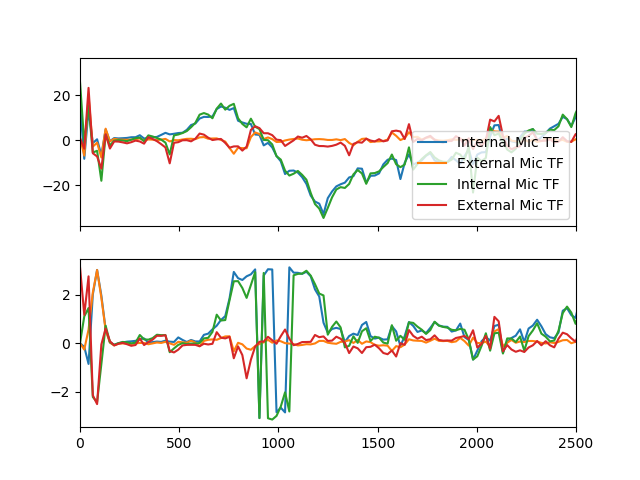

In [12]:
# Testing internal and external data
fig,ax = plt.subplots(2,sharex=True)
fig.set_label("Initial position (open) recordings, internal vs external spectra")

for acq in [acq1_open, acq2_open]:
    tf_int = 20*np.log10(np.abs(acq['tf_src_int']/refdata['tf_src_int']))
    angle_int = np.angle(acq['tf_src_int']/refdata['tf_src_int'])
    ax[0].plot(refdata['f_int'], tf_int, label="Internal Mic TF")
    ax[1].plot(refdata['f_int'], angle_int)

    tf_ext = 20*np.log10(np.abs(acq['tf_src_ext']/refdata['tf_src_ext']))
    angle_ext = np.angle(acq['tf_src_ext']/refdata['tf_src_ext'])
    ax[0].plot(refdata['f_ext'], tf_ext, label="External Mic TF")
    ax[1].plot(refdata['f_ext'], angle_ext)

    ax[0].legend(loc='lower right')
    ax[0].set_xlim((0, 2500))

<IPython.core.display.Javascript object>


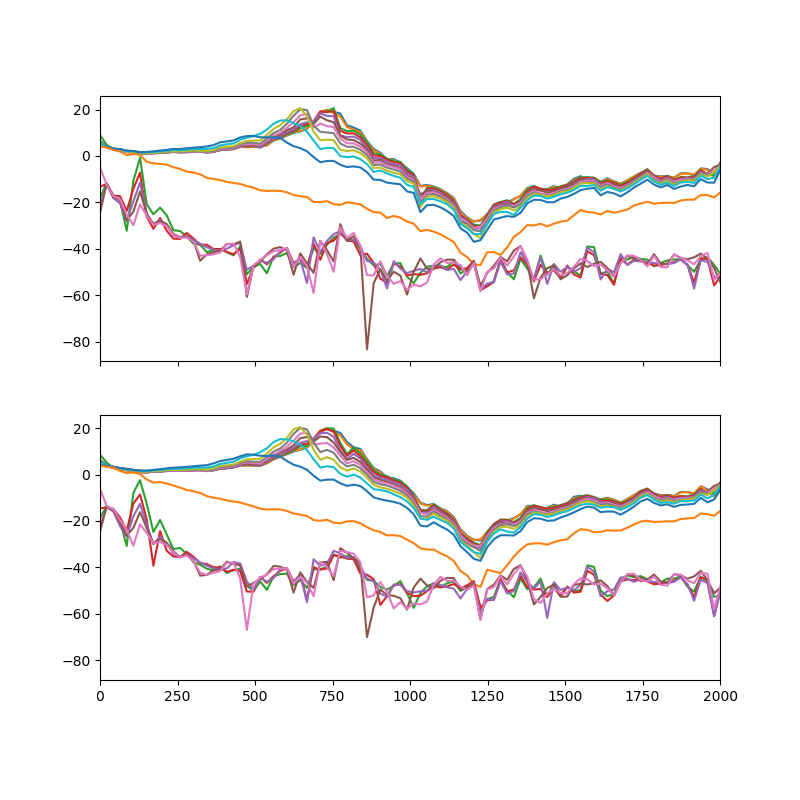

<IPython.core.display.Javascript object>


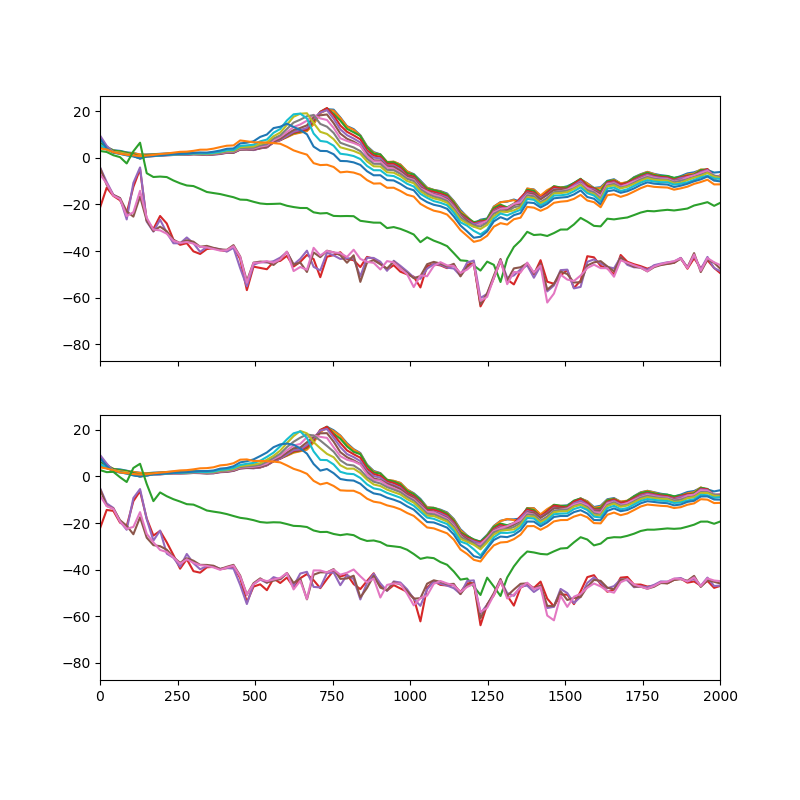

In [13]:
# Plotting TF (unfiltered + filtered)
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle

def full_extent(ax, pad=0.5):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

for acqno, acqdata in enumerate(data):
    fig,ax = plt.subplots(2,sharex=True, sharey=True, figsize=((8,8)))
    for r, rdata in enumerate(acqdata):
        tfraw = 20*np.log10(np.abs(rdata['tf']))
        tflevel = ftr.filter_tfdata(rdata['tf'], 2, 0.75)
        fvals = rdata['f']
        ax[0].set_xlim((0, 2000))
        ax[0].plot(fvals, tfraw)
        ax[1].plot(fvals, tflevel)
    extent = Bbox.union([full_extent(x) for x in ax[:]])
    extent = extent.transformed(fig.transFigure.inverted())
    rect = Rectangle([extent.xmin, extent.ymin], extent.width, extent.height,
                     facecolor='white', edgecolor='none', zorder=-1, 
                     transform=fig.transFigure)
    fig.patches.append(rect)
    plt.subplots_adjust(bottom=0.15)

In [14]:
# Obtaining resonance frequency data
Hfx = []
Hfy = []
for acqno, acqdata in enumerate(data):
    Hfx.append([])
    Hfy.append([])
    for r, rdata in enumerate(acqdata):
        fvals = rdata['f']
        tflevel = ftr.filter_tfdata(rdata['tf'], 2, 0.75)
        hfx, hfy = ftr.get_hf(tflevel, fvals, 100, 1000)
        Hfx[acqno].append(hfx)
        Hfy[acqno].append(hfy)

In [15]:
# Determining opening and closing values from resonance
keytrans = []
for acqno, acqdata in enumerate(data):
    ktrans = ()
    Hf = Hfx[acqno]
    openHf = max(Hf)
    closedHf = min(Hf)
    for r in range(RUNS):
        if Hf[r]==openHf and Hf[r+1]!=openHf:
            ktrans = ktrans+(r,)
        elif Hf[r]==closedHf:
            ktrans = ktrans+(r,)
            break
    keytrans.append(ktrans)

keytrans

[(4, 11), (5, 12)]

In [16]:
# Organising data and calculating model
Theoretical = {'efflen' : [], 'hfreq' : [], 'inert' : []}
Experimental = {'efflen' : [], 'hfreq' : Hfx, 'inert' : []}
for acqno, acqdata in enumerate(data):
    kopen = keytrans[acqno][0]
    kclsd = keytrans[acqno][1]
    keyincr = [(k-kclsd)*(-0.25) for k in np.arange(RUNS)]
    
    efflenT = []
    hfreqT = []
    inertT = []
    efflenE = []
    inertE = []
    for i, incr in enumerate(keyincr):
        model(incr*0.001)
        lab(Hfx[acqno][i], model)
        efflenT.append(model.efflen)
        hfreqT.append(model.helmfreq)
        inertT.append(model.inertance)
        efflenE.append(lab.efflen)
        inertE.append(lab.inertance)
               
    Theoretical['efflen'].append(efflenT)
    Theoretical['hfreq'].append(hfreqT)
    Theoretical['inert'].append(inertT)
    Experimental['efflen'].append(efflenE)
    Experimental['inert'].append(inertE)

<IPython.core.display.Javascript object>


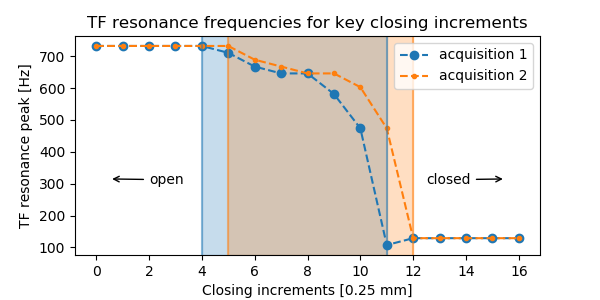

In [17]:
# Plotting resonance vs key displacement
fig = plt.figure(figsize=((6, 3)))
fmts = ['o--', '.--']
colors = ['b','g']
cmap = plt.get_cmap('tab10')
TransIncrs = [[np.linspace(keytrans[a][0],keytrans[a][1],8)] for a in [0,1]]
for acqno, acqdata in enumerate(data):
    plt.plot(np.arange(RUNS), Experimental['hfreq'][acqno], 
             str(fmts[acqno]), label='acquisition %d' %(acqno+1))
#     plt.plot(np.arange(RUNS), Theoretical['hfreq'][acqno], 
#              str(fmts[acqno]), alpha=0.5, color=colors[acqno], label='model %d' %(acqno+1))
    
# plt.axvspan(keytrans[0][1], keytrans[1][1], color='k', alpha=0.25)
# plt.axvspan(keytrans[0][0], keytrans[1][0], color='k', alpha=0.25)
# plt.axvspan(0, keytrans[0][0]+0.5, color='r', alpha=0.2)
# plt.axvspan(keytrans[1][1]-0.5, 16, color='r', alpha=0.2)
# plt.axvline(np.mean([keytrans[0][1], keytrans[1][1]]), color='k', alpha=0.5)
plt.axvline(keytrans[0][0], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][0], color=cmap(1), alpha=0.5)
plt.axvline(keytrans[0][1], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][1], color=cmap(1), alpha=0.5)
plt.axvspan(keytrans[0][0], keytrans[0][1], color=cmap(0), alpha=0.25)
plt.axvspan(keytrans[1][0], keytrans[1][1], color=cmap(1), alpha=0.25)
plt.annotate('closed', (np.mean([keytrans[0][1], keytrans[1][1]])+4, 315), 
             (np.mean([keytrans[0][1], keytrans[1][1]])+1, 300), 
             arrowprops=dict(arrowstyle='->'))
# plt.axvline(np.mean([keytrans[0][0], keytrans[1][0]]), color='k', alpha=0.5)
plt.annotate('open', (np.mean([keytrans[0][0], keytrans[1][0]])-4, 315), 
             (np.mean([keytrans[0][0], keytrans[1][0]])-2.5, 300), 
             arrowprops=dict(arrowstyle='->'))
plt.subplots_adjust(bottom=0.15)
plt.title('TF resonance frequencies for key closing increments')
plt.xlabel('Closing increments [0.25 mm]')
plt.ylabel('TF resonance peak [Hz]')
plt.legend(loc='upper right')

# plt.savefig('TF-resonance.png')

<IPython.core.display.Javascript object>


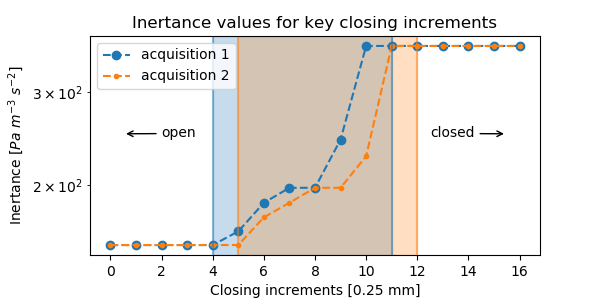

In [20]:
# Plotting inertance vs key displacement
fig = plt.figure(figsize=((6, 3)))
fmts = ['o--', '.--']
for acqno, acqdata in enumerate(data):
    plt.semilogy(np.arange(RUNS), Experimental['inert'][acqno], 
             str(fmts[acqno]), label='acquisition %d' %(acqno+1))
#     plt.semilogy(np.arange(RUNS), Theoretical['inert'][acqno], 
#              str(fmts[acqno]), alpha=0.5, label='model %d' %(acqno+1))
    
# plt.axvspan(keytrans[0][1], keytrans[1][1], color='k', alpha=0.25)
# plt.axvspan(keytrans[0][0], keytrans[1][0], color='k', alpha=0.25)
# plt.axvspan(0, keytrans[0][0]+0.5, color='r', alpha=0.2)
# plt.axvspan(keytrans[1][1]-0.5, 16, color='r', alpha=0.2)
# plt.axvline(np.mean([keytrans[0][1], keytrans[1][1]]), color='k', alpha=0.5)
plt.axvline(keytrans[0][0], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][0], color=cmap(1), alpha=0.5)
plt.axvline(keytrans[0][1], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][1], color=cmap(1), alpha=0.5)
plt.axvspan(keytrans[0][0], keytrans[0][1], color=cmap(0), alpha=0.25)
plt.axvspan(keytrans[1][0], keytrans[1][1], color=cmap(1), alpha=0.25)
plt.annotate('closed', (np.mean([keytrans[0][1], keytrans[1][1]])+4, 250), 
             (np.mean([keytrans[0][1], keytrans[1][1]])+1, 246), 
             arrowprops=dict(arrowstyle='->'))
# plt.axvline(np.mean([keytrans[0][0], keytrans[1][0]]), color='k', alpha=0.5)
plt.annotate('open', (np.mean([keytrans[0][0], keytrans[1][0]])-4, 250), 
             (np.mean([keytrans[0][0], keytrans[1][0]])-2.5, 246), 
             arrowprops=dict(arrowstyle='->'))
plt.subplots_adjust(bottom=0.15)
plt.title('Inertance values for key closing increments')
plt.xlabel('Closing increments [0.25 mm]')
plt.ylabel('Inertance [$Pa$ $m^{-3}$ $s^{-2}$]')
plt.legend(loc='upper left')
plt.gcf().subplots_adjust(left=0.15)

# plt.savefig('TF-inertance.png')

<IPython.core.display.Javascript object>


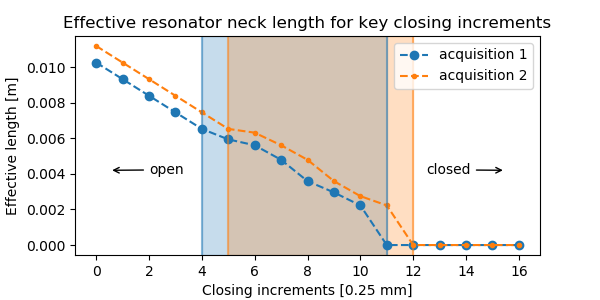

In [21]:
# Plotting effective length vs key displacement
fig = plt.figure(figsize=((6, 3)))
fmts = ['o--', '.--']
for acqno, acqdata in enumerate(data):
    plt.plot(np.arange(RUNS), Experimental['efflen'][acqno], 
             str(fmts[acqno]), label='acquisition %d' %(acqno+1))
#     plt.plot(np.arange(RUNS), Theoretical['efflen'][acqno], 
#              str(fmts[acqno]), alpha=0.5, label='model %d' %(acqno+1))
    
# plt.axvspan(keytrans[0][1], keytrans[1][1], color='k', alpha=0.25)
# plt.axvspan(keytrans[0][0], keytrans[1][0], color='k', alpha=0.25)
# plt.axvspan(0, keytrans[0][0]+0.5, color='r', alpha=0.2)
# plt.axvspan(keytrans[1][1]-0.5, 16, color='r', alpha=0.2)
# plt.axvline(np.mean([keytrans[0][1], keytrans[1][1]]), color='k', alpha=0.5)
plt.axvline(keytrans[0][0], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][0], color=cmap(1), alpha=0.5)
plt.axvline(keytrans[0][1], color=cmap(0), alpha=0.5)
plt.axvline(keytrans[1][1], color=cmap(1), alpha=0.5)
plt.axvspan(keytrans[0][0], keytrans[0][1], color=cmap(0), alpha=0.25)
plt.axvspan(keytrans[1][0], keytrans[1][1], color=cmap(1), alpha=0.25)
plt.annotate('closed', (np.mean([keytrans[0][1], keytrans[1][1]])+4, 0.0042), 
             (np.mean([keytrans[0][1], keytrans[1][1]])+1, 0.004), 
             arrowprops=dict(arrowstyle='->'))
# plt.axvline(np.mean([keytrans[0][0], keytrans[1][0]]), color='k', alpha=0.5)
plt.annotate('open', (np.mean([keytrans[0][0], keytrans[1][0]])-4, 0.0042), 
             (np.mean([keytrans[0][0], keytrans[1][0]])-2.5, 0.004), 
             arrowprops=dict(arrowstyle='->'))
plt.subplots_adjust(bottom=0.15)
plt.title('Effective resonator neck length for key closing increments')
plt.xlabel('Closing increments [0.25 mm]')
plt.ylabel('Effective length [m]')
plt.legend(loc='upper right')

# plt.savefig('TF-efflen.png')

In [64]:
flatHF = Experimental['hfreq']
%store flatHF
flatLL = Experimental['inert']
%store flatLL
flatTrans = keytrans
%store flatTrans

Stored 'flatHF' (list)
Stored 'flatLL' (list)
Stored 'flatTrans' (list)
